In [1]:
import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip, SigmaClip
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import gaussian_fwhm_to_sigma

from photutils.background import Background2D, MedianBackground, StdBackgroundRMS
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog

import matplotlib.pyplot as plt

In [2]:
load_sim_datamap_func = lambda sim, ID, cl: fits.open(f"/mnt/d/SRHerschel500/data/raw/sim datamaps/{sim}_{ID}_SPIRE{cl}_smoothed_Jy_beam.fits")[0].data
load_obs_datamap_func = lambda ID, cl: fits.open(f"/mnt/d/SRHerschel500/data/raw/obs datamaps/COSMOS-Nest_image_{cl}_SMAP_v6.0.fits")[1].data

In [3]:
sim250 = load_sim_datamap_func(sim='SIDES', ID=1, cl=250)*1e3

In [4]:
# Read the catalog and convert it to a pandas DataFrame
cat = Table.read('/mnt/d/SRHerschel500/data/raw/catalogs/sim/SIDES_cat1.fits', hdu=1)
df_cat = cat.to_pandas()

# Rename columns for consistent naming
df_cat.rename(columns={'ra': 'RA', 'dec': 'DEC'}, inplace=True)

# Convert the flux values from Jy to mJy for the specified bands
for col in ['SSPIRE250', 'SSPIRE350', 'SSPIRE500']:
    df_cat[col] *= 1e3

# Display the first few rows of the DataFrame
df_cat.head()

,RA,DEC,SMIPS24,SSPIRE250,SSPIRE350,SSPIRE500
0,21.386314,0.578664,0.000000,0.000000,0.000000,0.000000
1,20.454959,1.145274,0.007663,123.211292,53.103800,19.491508
2,20.653517,1.053531,0.000000,0.000000,0.000000,0.000000
3,20.931048,0.651234,0.139414,401.735406,145.287778,47.679960
4,20.787421,0.940826,0.004839,42.325019,17.436835,6.216499


In [5]:
def create_catalog_hdu(catalog, pixel_scale, fwhm):
    # Assume catalog is a DataFrame with columns 'RA', 'DEC', 'flux'
    # Use the median of RA/DEC for the reference coordinate
    ra_ref = np.median(catalog['RA'])
    dec_ref = np.median(catalog['DEC'])
    
    # Set up a basic WCS for a TAN (gnomonic) projection.
    w = WCS(naxis=2)
    w.wcs.crval = [ra_ref, dec_ref]
    w.wcs.crpix = [0.5, 0.5]  # reference pixel at the lower corner
    # Set pixel scale: note the negative sign for RA to preserve sky orientation.
    cdelt = pixel_scale/3600.0
    w.wcs.cdelt = np.array([cdelt, cdelt])
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

    # Determine image boundaries (in pixel) from the catalog positions.
    pix_coords = w.wcs_world2pix(np.column_stack((catalog['RA'], catalog['DEC'])), 1)
    x_min, y_min = pix_coords.min(axis=0)
    x_max, y_max = pix_coords.max(axis=0)
    # Give some margin (optional)
    margin = 0
    nx = int(np.ceil(x_max - x_min)) + 2*margin
    ny = int(np.ceil(y_max - y_min)) + 2*margin

    # Create an empty image. It will have flux in mJy/beam.
    image = np.zeros((ny, nx), dtype=np.float32)

    # Offset pixel coordinates so that the minimum position starts at margin.
    offset = np.array([x_min - margin, y_min - margin])
    
    # Place each catalog source into the image.
    # Here we simply add the flux at the nearest pixel.
    pix_coords = w.wcs_world2pix(np.column_stack((catalog['RA'], catalog['DEC'])), 1)
    for (x, y, flux) in zip(pix_coords[:, 0], pix_coords[:, 1], catalog['SSPIRE250']):
        ix, iy = int(np.round(x - offset[0])), int(np.round(y - offset[1]))
        if 0 <= ix < nx and 0 <= iy < ny:
            image[iy, ix] += flux

    # Convolve image with a Gaussian beam based on the user input fwhm (arcsec)
    # Convert FWHM (arcsec) to sigma (in pixels)
    sigma_pix = fwhm * gaussian_fwhm_to_sigma / pixel_scale

    print(sigma_pix, gaussian_fwhm_to_sigma, pixel_scale)
    # Set kernel size to cover ±3sigma
    kernel_size = int(np.ceil(6 * sigma_pix))
    if kernel_size % 2 == 0:
        kernel_size += 1
    kernel = Gaussian2DKernel(sigma_pix, x_size=kernel_size, y_size=kernel_size)
    kernel.normalize(mode="peak")
    image = convolve_fft(image, kernel, normalize_kernel=False, boundary='wrap')

    # Update WCS so that the new reference pixel is adjusted.
    new_w = w.deepcopy()
    new_w.wcs.crpix = w.wcs.crpix - offset

    hdu = fits.PrimaryHDU(data=image, header=new_w.to_header())
    hdu.header['BUNIT'] = 'mJy/beam'
    return hdu

# Example usage:
# Assume you have a pandas DataFrame "catalog" with columns 'RA', 'DEC', 'flux'
# along with a pixel scale and a beam FWHM provided by the user.
pixel_scale = 2  # arcsec/pixel (user input)
fwhm = 6       # beam FWHM in arcsec (user input)

hdu = create_catalog_hdu(df_cat, pixel_scale, fwhm)

# # To write the image to a FITS file (optional):
# hdu.writeto('catalog_image.fits', overwrite=True)
print("Catalog image created successfully.")

1.2739827004320285 0.42466090014400953 2
Catalog image created successfully.


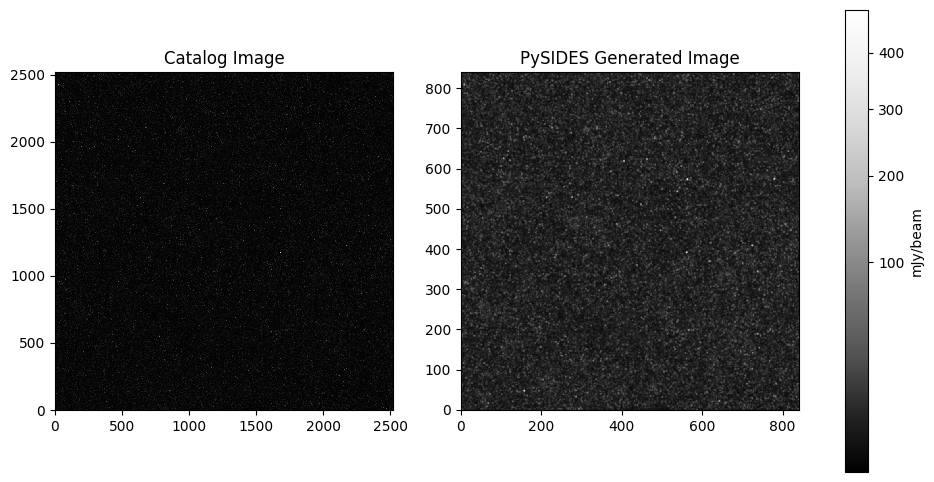

In [6]:
norm = ImageNormalize(stretch=SqrtStretch())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im0 = axes[0].imshow(hdu.data, norm=norm, origin='lower', cmap='Greys_r',
                     interpolation='nearest')
axes[0].set_title("Catalog Image")

im1 = axes[1].imshow(sim250, norm=norm, origin='lower', cmap='Greys_r',
                     interpolation='nearest')
axes[1].set_title("PySIDES Generated Image")

fig.colorbar(im0, ax=axes, orientation='vertical', label='mJy/beam')
plt.show()

In [7]:
np.min(sim250)

0.4739054285238019

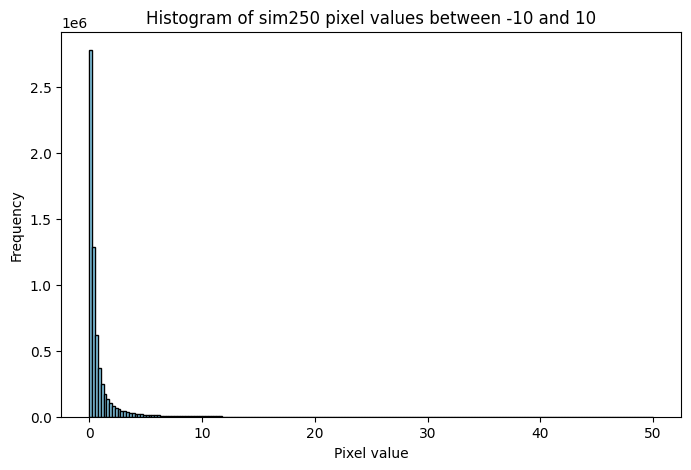

In [24]:
# Filter out NaN values from sim250
data_clean = sim250.copy()
data_clean[np.isnan(data_clean)] = 0.

# Plot the histogram for pixel values between -10 and 10
plt.figure(figsize=(8, 5))
plt.hist(hdu.data.flatten(), bins=200, range=(0, 50), color='skyblue', edgecolor='black')
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.title("Histogram of sim250 pixel values between -10 and 10")
plt.show()

In [9]:
import numpy as np
from astropy.stats import biweight_location
print(np.median(sim250))
print(biweight_location(sim250))

6.279692630805985
6.433221656053435


In [10]:
from astropy.stats import mad_std
print(mad_std(sim250))

3.992013585421103


In [11]:
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
sigma_clip = SigmaClip(sigma=2.0, maxiters=100)
threshold = detect_threshold(sim250, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(sim250, threshold, npixels=5)
footprint = circular_footprint(radius=10)
mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(sim250, sigma=3.0, mask=mask, maxiters=100)
print(np.array((mean, median, std)))

[2.66554039 2.63989677 1.05417648]


In [25]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=2, maxiters=50)
bkg_estimator = MedianBackground()

# Create the background model
bkg = Background2D(hdu.data, (100, 100), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, exclude_percentile=99.9)

In [26]:
print(bkg.background_median)
print(bkg.background_rms_median)

0.11280766048788896
0.05325302316856681


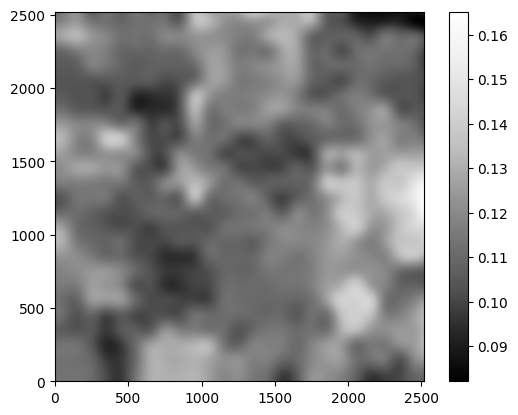

In [27]:
img = plt.imshow(bkg.background, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.colorbar(img)
plt.show()

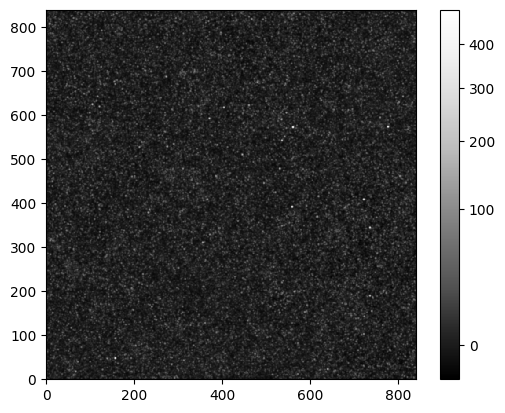

In [15]:
norm = ImageNormalize(stretch=SqrtStretch())
img = plt.imshow(sim250 - bkg.background, norm=norm, origin='lower',
           cmap='Greys_r', interpolation='nearest')

plt.colorbar(img)
plt.show()

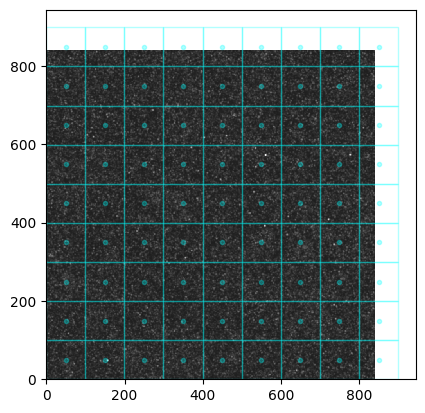

In [16]:
plt.imshow(sim250, origin='lower', cmap='Greys_r', norm=norm,
           interpolation='nearest')
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.3)